## <center>Torrance Learning eLearning User Data Analysis</center>
##### Project Abstract: 
The American Spinal Injury Association (ASIA) uses learning content and a learning management system (LMS) provided by TorranceLearning (TL). TL are curious to explore the usage patterns by course, by user type and pre/during/post pandemic. Some of the questions that TL is looking for answers to include:

* how many courses do people take? 
* what is the most common order of courses taken? 
* do people who pay for the course take a different number of courses? 
* how much of the free/optional content do people consume after paying for / not paying for the primary course? 

Code Author: Riddhisha Prabhu (UMich Applied Data Science)

#### DATA LOADING AND PROCESSING

The client has provided data mainly in the form of two cvs files:

   (1) Course Metadata: as the name implies, this file contains metadata about each course, such as the courseID and the underlying modules within each course. Our analysis for this project is limited to the course level and not the underlying module level
   
   (2) ASIA Master Data de-ID: contains eLearning platform usage data for each user. This is the primary data for our analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df_meta = pd.read_excel("Course Metadata.xlsx")
df_meta.info()
df_meta.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Course ID  62 non-null     object
 1   Course     62 non-null     object
 2   Type       62 non-null     object
 3   Type2      62 non-null     object
 4   Language   62 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB


,Course ID,Course,Type,Type2,Language
0,E-As-EN-001-1,ASTeP Part 1 - Autonomic Anatomy & Function(87...,Elearning,Module,English
1,E-As-EN-001-1,ASTeP: Autonomic Anatomy & Function(875005),Elearning,Module,English
2,E-As-EN-001-2,ASTeP Part 2 - Standards Form(875008),Elearning,Module,English


In [2]:
df_asia = pd.read_excel("ASIA Master Data de-ID.xlsx")
df_asia.info()

##Data Transformation: Per discussions with the client:
    ##(1) dropping columns with blanks/non useful information
    ##(2) dropping rows with no UserID
df_asia.drop(["Column11","GroupByColumn1","GroupByColumn3","Category"], axis = 1, inplace = True)      #(1)
df_asia = df_asia[df_asia["UserID"].notnull()]                                        #(2)
df_asia.head(3)


##Further, per the client, both "ASIA" and "Steel Assembly" providers should be included in our analysis; Steel Assembly is 
##the sponsor and for the purposes of this analysis, they should be treated the same

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25036 entries, 0 to 25035
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   UserID             25001 non-null  object        
 1   User Domain        25036 non-null  object        
 2   Enrollment Date    25036 non-null  datetime64[ns]
 3   First Launch Date  18544 non-null  datetime64[ns]
 4   Status             25036 non-null  object        
 5   Completion Date    13428 non-null  datetime64[ns]
 6   Price              25036 non-null  int64         
 7   Time (in Hours)    25036 non-null  float64       
 8   Score              25036 non-null  int64         
 9   Course             25036 non-null  object        
 10  Column11           0 non-null      float64       
 11  GroupByColumn1     25036 non-null  object        
 12  GroupByColumn3     0 non-null      float64       
 13  Provider           25036 non-null  object        
 14  Media 

,UserID,User Domain,Enrollment Date,First Launch Date,Status,Completion Date,Price,Time (in Hours),Score,Course,Provider,Media
0,A002223,ASIA User,2019-11-12 14:50:34,2021-10-08,Complete,2021-10-08 12:08:22,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME
1,A004695,ASIA User,2019-11-12 14:50:34,2019-11-27,Complete,2019-11-27 12:34:00,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME
2,A002173,ASIA User,2019-11-12 14:50:35,2019-12-09,Complete,2019-12-09 15:43:00,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME


In [3]:
##merging both datasets

merged_df = pd.merge(df_asia,df_meta, how="left", left_on="Course", right_on="Course")
merged_df.head(2)

,UserID,User Domain,Enrollment Date,First Launch Date,Status,Completion Date,Price,Time (in Hours),Score,Course,Provider,Media,Course ID,Type,Type2,Language
0,A002223,ASIA User,2019-11-12 14:50:34,2021-10-08,Complete,2021-10-08 12:08:22,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME,E-In-EN-001,Elearning,Certificate,English
1,A004695,ASIA User,2019-11-12 14:50:34,2019-11-27,Complete,2019-11-27 12:34:00,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME,E-In-EN-001,Elearning,Certificate,English


In [4]:
##Data Transformation: the next few functions append the data with markers based on the info shared by the client
    ##(3) adding a columns to identify student as "User Domain" == "Bulk Upload Instep" [def categorize(x)]
    ##(4) adding Pre/Pandemic/Post information per Enrollment Data [def period(x)]
    ##(5) adding information on coursetype [def course_type(x)]
    ##(6) dropping surveys


## (3) student vs professional
def categorize(x):
    if x =="Bulk Upload Instep": 
        return "Student"
    else: return "Professional"
    

## (4) Pre-pandemic is before Mar 1, 2020; Pandemic is March 1 through Dec 31, 2021; and Post is Jan 1, 2022 – through current)
def period(x):
    if x < pd.to_datetime('03/01/2020'):
        return "Pre-pandemic"
    elif x>= pd.to_datetime('03/01/2020') and x <= pd.to_datetime('12/31/2021'):
        return "Pandemic"
    else: return "Post-pandemic"


merged_df["User_Type"] = merged_df["User Domain"].apply(lambda x: categorize(x))          #(3)
merged_df["Period"] = merged_df["Enrollment Date"].apply(lambda x: period(x))             #(4)    
    
merged_df.head(2)

,UserID,User Domain,Enrollment Date,First Launch Date,Status,Completion Date,Price,Time (in Hours),Score,Course,Provider,Media,Course ID,Type,Type2,Language,User_Type,Period
0,A002223,ASIA User,2019-11-12 14:50:34,2021-10-08,Complete,2021-10-08 12:08:22,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME,E-In-EN-001,Elearning,Certificate,English,Professional,Pre-pandemic
1,A004695,ASIA User,2019-11-12 14:50:34,2019-11-27,Complete,2019-11-27 12:34:00,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME,E-In-EN-001,Elearning,Certificate,English,Professional,Pre-pandemic


In [5]:
## (5 and 6) course_type original
def course_type(x):
    courses = {"E-As":"AStep",
               "E-In":"InStep",
               "E-Sk":"SkinStep", 
               "E-SP":"SpaStep",
               "E-We":"WeeStep",
               "W-EN":"Webinar", 
               "W-SP":"Webinar", #Treating Spanish and English webinars the same
               "E-SU":"Survey",   
               "W-SU":"Survey"}     
    return courses[x[0:4]]
    
merged_df["CourseType"] = merged_df["Course ID"].apply(lambda x:course_type(x))       #(5)
# print(len(merged_df))


#Per discussion with client, excluding surveys                                        #(6)
merged_df = merged_df[merged_df["CourseType"]!= "Survey"]
# print(len(merged_df))


merged_df.sort_values("Enrollment Date", inplace = True)
merged_df.head(2)

,UserID,User Domain,Enrollment Date,First Launch Date,Status,Completion Date,Price,Time (in Hours),Score,Course,Provider,Media,Course ID,Type,Type2,Language,User_Type,Period,CourseType
0,A002223,ASIA User,2019-11-12 14:50:34,2021-10-08,Complete,2021-10-08 12:08:22,50,0.0,0,InSTeP: International Standards 2019(874713),ASIA,Certificate with CME,E-In-EN-001,Elearning,Certificate,English,Professional,Pre-pandemic,InStep
8714,A002223,ASIA User,2019-11-12 14:50:34,2021-10-08,Waived,NaT,0,0.0,0,InSTeP Module 3 - Motor Exam(874717),ASIA,Online,E-In-EN-001-3,Elearning,Module,English,Professional,Pre-pandemic,InStep


#### ANALYSIS AND OBSERVATIONS:

In [6]:
##(1) how many courses (not modules within a course) do people take on average?


# merged_df.groupby(["User_Type","CourseType"]).agg({"UserID":len})
# temp.apply({"CourseType":[np.mean,np.median,np.std,min, max]}).round(2)
# temp

# temp.groupby("User_Type").agg({"CourseType":[np.mean,np.median,np.std,min, max]}).round(2)

In [7]:
##(2) Client Question: In what order do users take courses? / Check assumption that people start with the InSTep course


merged_df = merged_df[(merged_df["Status"] != "Not Started") & (merged_df["Status"] != "Waived")]
usertype = ["Professional","Student"]


test = {}
for user in usertype:
    sub_df = merged_df[merged_df["User_Type"]==user]
    
   
    ##find first course:
    starts = {}      #absolute number of users starting with each course
    startsp = {}     #of users starting with each course

    
    ##we group by each studentID and we increase the counter(starts) based on the course this student started with
    for group, frame in sub_df.groupby("UserID"):
        frame.sort_values("Enrollment Date", inplace = True)

        if frame.iloc[0,18] == "InStep":
            starts["InStep"] = starts.get("InStep",0) + 1 
        elif frame.iloc[0,18] == "AStep":
            starts["AStep"] = starts.get("AStep",0) + 1 
        elif frame.iloc[0,18] == "SpaStep":
            starts["SpaStep"] = starts.get("SpaStep",0) + 1 
        elif frame.iloc[0,18] == "SkinStep":
            starts["SkinStep"] = starts.get("SkinStep",0) + 1 
        elif frame.iloc[0,18] == "WeeStep":
            starts["WeeStep"] = starts.get("WeeStep",0) + 1 
    
#     print(starts) 
    total = 0
    for v in starts.values(): 
        total += v
    for k,v in starts.items():
        startsp[k] = round(v/total *100,2)
#     print(startsp)
    
    test[user] = startsp
    test_pd = pd.DataFrame(test)

test_pd

,Professional,Student
AStep,9.27,57.47
InStep,83.11,40.77
SkinStep,2.77,NaN
WeeStep,2.41,1.75
SpaStep,2.44,NaN


In [8]:
##find second course:
       ## (A) For professionals, since a majority of the users start with InSTep, for simplicity, we just check what course, if any, 
       ##users take after instep

       ## (B)For students, we check which course they move onto after starting (B1) AStep or (B2) InStep


##(A) Professional Users that start with Instep; what do they take next
sub_df = merged_df[merged_df["User_Type"]=="Professional"]

prof_next = {}
for group, frame in sub_df.groupby("UserID"):
    frame.sort_values("Enrollment Date", inplace = True)
   
    if frame.iloc[0,18] == "InStep":
        temp = frame[frame["CourseType"] != "InStep"]
        if len(temp) == 0: 
            prof_next["None"] = prof_next.get("None",0) + 1
        elif temp.iloc[0,18] == "AStep":
            prof_next["AStep"] = prof_next.get("AStep",0) + 1 
        else:
            prof_next["Other"] = prof_next.get("Other",0) + 1 
        
# print(nextcourse)

prof_nextp = {}
total = 0
for v in prof_next.values(): 
    total += v
for k,v in prof_next.items():
    prof_nextp[k] = round(v/total *100,2)

prof_nextp

{'None': 62.14, 'Other': 5.98, 'AStep': 31.88}

In [9]:
##B
##(B) Student Users that start with (B1) ASTep and (B2) InStep; what do they take next
sub_df = merged_df[merged_df["User_Type"]=="Student"]

student_next_a = {}
student_next_i = {}
for group, frame in sub_df.groupby("UserID"):
    frame.sort_values("Enrollment Date", inplace = True)
   
    ##(B1)
    if frame.iloc[0,18] == "AStep":
        temp = frame[frame["CourseType"] != "AStep"]
        if len(temp) == 0: 
            student_next_a["None"] = student_next_a.get("None",0) + 1
        elif temp.iloc[0,18] == "InStep":
            student_next_a["InStep"] = student_next_a.get("InStep",0) + 1 
        else: 
            student_next_a["Other"] = student_next_a.get("Other",0) + 1
            
    ##(B2)            
    elif frame.iloc[0,18] == "InStep":     
        temp = frame[frame["CourseType"] != "InStep"]
        if len(temp) == 0: 
            student_next_i["None"] = student_next_i.get("None",0) + 1
        elif temp.iloc[0,18] == "AStep":
            student_next_i["AStep"] = student_next_i.get("AStep",0) + 1 
        else: 
            student_next_i["Other"] = student_next_i.get("Other",0) + 1 
 
# print(student_next_a)
# print(student_next_i)


student_next_ap = {}
student_next_ip = {}


total = 0
for v in student_next_a.values(): 
    total += v
for k,v in student_next_a.items():
    student_next_ap[k] = round(v/total *100,2)

print("AStep starter students:")
print(student_next_ap)

total = 0
for v in student_next_i.values(): 
    total += v
for k,v in student_next_i.items():
    student_next_ip[k] = round(v/total *100,2)

print("InStep starter students:")
print(student_next_ip)

AStep starter students:
{'InStep': 84.43, 'None': 11.4, 'Other': 4.17}
InStep starter students:
{'None': 78.96, 'Other': 3.85, 'AStep': 17.19}


<IPython.core.display.Javascript object>


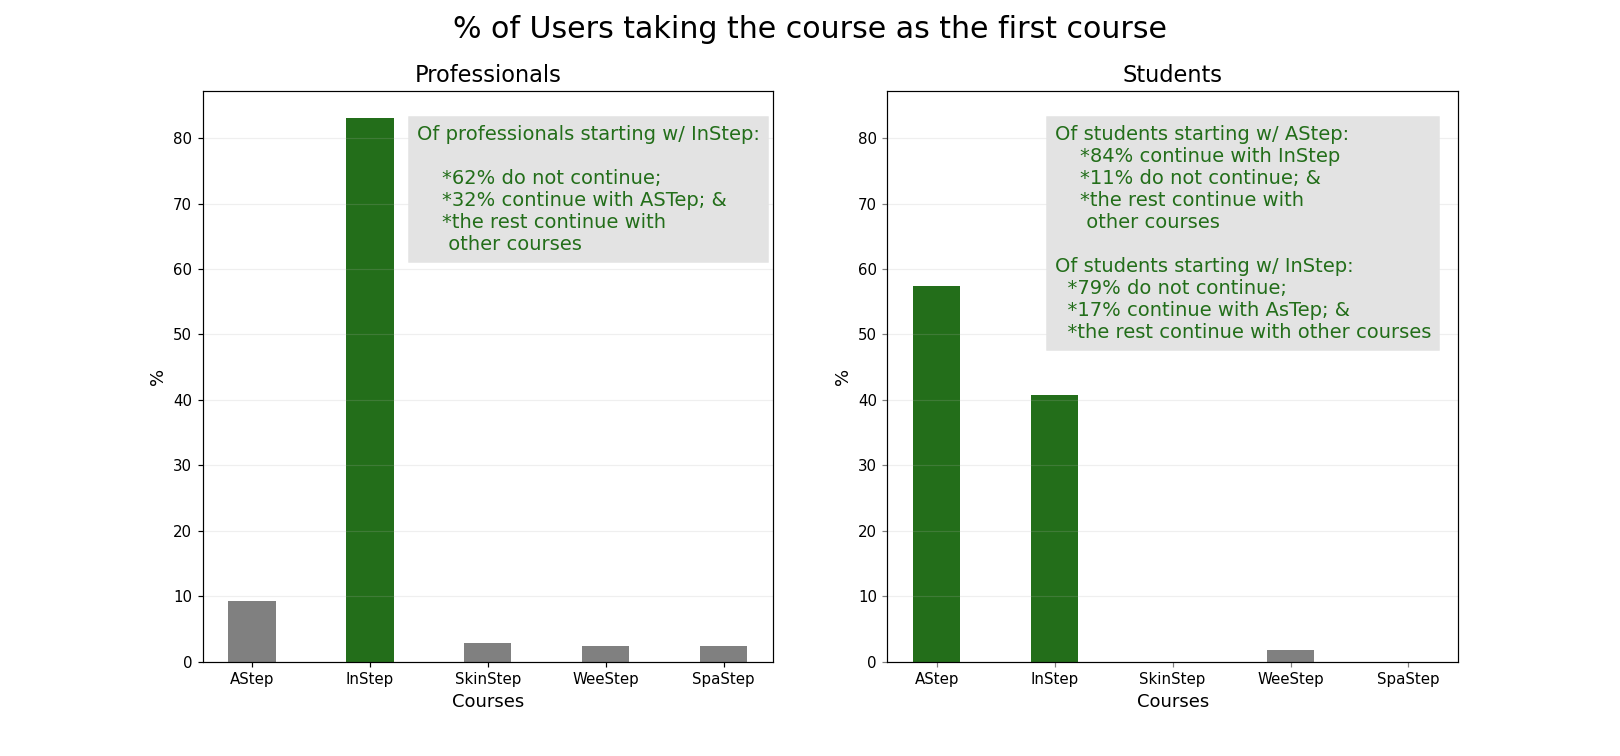

In [21]:
%matplotlib notebook
plt.figure(figsize = (15,7));


# xlist = ["InSTeP","ASTeP","SkinSTeP","WeeSTep","SpAsTeP"]

plt.subplot(1,2,1);
clrs1 = ['grey' if (x < np.max(test_pd["Professional"])) else '#236E1A' for x in test_pd["Professional"]];
plt.bar(x =  test_pd.index, height = test_pd["Professional"], width =0.4, color = clrs1);
plt.grid(axis = "y", alpha =0.2);
plt.tick_params(axis='both', labelsize=10);
plt.xlabel("Courses", fontsize = 12, color = "black");
plt.ylabel("%", fontsize = 12, color = "black");
plt.title("Professionals", fontsize = 15, color = "black");

##Text is based on prof_nextp
plt.text(x=1.4,y=82, s = """Of professionals starting w/ InStep:

    *62% do not continue;
    *32% continue with ASTep; &
    *the rest continue with 
     other courses""", va = "top", backgroundcolor = "#E3E3E3", color = "#236E1A", fontsize = 13);


plt.subplot(1,2,2, sharey = plt.subplot(1,2,1), sharex = plt.subplot(1,2,1));
# clrs2 = ['grey' if (x < np.max(test_pd["Student"])) else '#4d804d' for x in test_pd["Student"]];
clrs2 = ['grey' if x < float(40) else '#236E1A' for x in test_pd["Student"]];
plt.bar(x = test_pd.index, height = test_pd["Student"], width =0.4, color = clrs2);
plt.grid(axis = "y", alpha =0.2);
plt.tick_params(axis='both', labelsize=10, color = "grey");
plt.xlabel("Courses", fontsize = 12, color = "black");
plt.ylabel("%", fontsize = 12, color = "black");
plt.title("Students", fontsize = 15, color = "black");

##Text is based on student_next_ap & student_next_ip
plt.text(x=1,y=82, s = """Of students starting w/ AStep:
    *84% continue with InStep
    *11% do not continue; &
    *the rest continue with 
     other courses

Of students starting w/ InStep:
  *79% do not continue;
  *17% continue with AsTep; &
  *the rest continue with other courses""",va = "top", backgroundcolor = "#E3E3E3", color = "#236E1A", fontsize = 13);

plt.suptitle("% of Users taking the course as the first course", fontsize = 20, color = "black");
plt.show()